In [6]:
import os
import glob
import itertools
import json
import importlib
import copy

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl

In [7]:
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.correlations as cr
import analyze2p.scatter as sct

In [8]:
%matplotlib notebook

In [9]:
# import sys
# !{sys.executable} -m pip install shapely

# Source data

In [10]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

## Metdata

In [11]:
# Load RF fit params for good rois
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# cells, missing_seg = aggr.get_cells_by_area(sdata, return_missing=True)
meta = sdata[sdata.experiment.isin(['rfs', 'rfs10'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                                  if (va, dk) in all_dkeys])
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
|    |   visual_area |
|:---|--------------:|
| V1 |            18 |
| Li |            15 |
| Lm |            15 |


## Select data and output

In [12]:
# Load trial metrics
experiment='rfs'
trial_epoch = 'stimulus'
traceid='traces001'
response_type='dff'
responsive_test='nstds'
responsive_thr=7
# ---------------------------------------------
responsive_str = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs10_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl
Stimulus: rfs (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |          1766 |
| Lm |          1366 |
| Li |           797 |


## Load RF fits

In [13]:
import analyze2p.objects.sim_utils as su

In [14]:
# experiment = 'rfs'
response_type='dff'
do_spherical_correction=False
# ---------------------------------------------------------------
# Get RF fit description (tag for which RF analysis to load)
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                   do_spherical_correction=do_spherical_correction)
rfdf = rfutils.aggregate_fits(CELLS,meta,
                        response_type=response_type,
                        do_spherical_correction=do_spherical_correction,
                        reliable_only=True, pass_criterion=['position', 'size'], 
                        combine='select', ecc_center=(0, 20))
# Add ROI positions
rfdf = aggr.add_roi_positions(rfdf.copy())
# Get polygons
try:
    rfpolys, _ = su.load_rfpolys(rf_fit_desc)
except FileNotFoundError as e:
    rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, create_new=True)
    
# data id
rf_correction_str = 'sphrcorr' if do_spherical_correction else 'uncorr'
rf_str = 'rfs-%s-%s' % (response_type, rf_correction_str)
data_id = '|'.join([traceid, responsive_str, rf_str])
print(data_id)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4
traces001|dff_responsive-nstds-thr7.00|rfs-dff-uncorr


In [501]:
# Set output dir
rf_type = 'rfs_sphrcorr' if do_spherical_correction else 'rfs_uncorr'
corr_dir = os.path.join(aggregate_dir, 'correlations', 
                       'rfs_%s_%s' % (response_type, responsive_test))
dst_dir = os.path.join(corr_dir, '%s_metrics' % rf_type)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

examples_dir = os.path.join(dst_dir, 'examples')
if not os.path.exists(examples_dir):
    os.makedirs(examples_dir)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES','correlations')
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics


## Add projection and scatter info

In [16]:
ecc_center=(0, 20)
no_rfs=[]; bad_fits=[];
a_list=[]
for (va, dk, exp), g in rfdf.groupby(['visual_area', 'datakey', 'experiment']):
    regr_np = sct.load_models(dk, va)
    aligned_ = sct.predict_soma_from_gradient(dk, va, regr_np, experiment=exp,
                                response_type=response_type,ecc_center=ecc_center,
                                do_spherical_correction=do_spherical_correction)
#     aligned_ = sct.project_soma_position_in_fov(dk, va, experiment=exp,
#                                 response_type=response_type,
#                                 do_spherical_correction=do_spherical_correction)
    if (regr_np['R2']<0.5).values.all():
        bad_fits.append((va, dk, exp))
        continue
    if aligned_ is None:
        no_rfs.append((va, dk, exp))
        continue
    for p in ['R2', 'RMSE', 'coefficient', 'intercept']:
        r2_ml = float(regr_np[regr_np.cond=='az'][p])
        r2_ap = float(regr_np[regr_np.cond=='el'][p])
        aligned_['gradient_%s_ml' % p] = r2_ml
        aligned_['gradient_%s_ap' % p] = r2_ap
    aligned_['visual_area']==va
    aligned_['datakey'] = dk
    aligned_['experiment'] = exp
    a_list.append(aligned_)
aligned_soma = pd.concat(a_list, axis=0, ignore_index=True)
aligned_soma.head()

,x0,y0,fwhm_x,fwhm_y,theta,offset,amplitude,r2,std_x,std_y,...,dist_scatter_ap,inbounds,gradient_R2_ml,gradient_R2_ap,gradient_RMSE_ml,gradient_RMSE_ap,gradient_coefficient_ml,gradient_coefficient_ap,gradient_intercept_ml,gradient_intercept_ap
0,13.970937,-5.799440,20.774773,16.374824,3.430451,-0.008447,0.113912,0.554930,8.840329,6.968010,...,284.600976,True,0.996587,0.997835,1.052717,0.234689,0.11699,0.025573,-44.321214,-16.272389
1,22.098769,-0.247358,39.817408,27.308256,0.420156,-0.001327,0.089209,0.714423,16.943578,11.620534,...,80.923033,True,0.996587,0.997835,1.052717,0.234689,0.11699,0.025573,-44.321214,-16.272389
2,16.905663,-3.145847,30.761553,22.510953,0.578259,0.001873,0.048070,0.634111,13.090023,9.579129,...,118.255902,True,0.996587,0.997835,1.052717,0.234689,0.11699,0.025573,-44.321214,-16.272389
3,15.673189,-1.585387,36.035211,24.158411,0.186008,0.000862,0.145984,0.882504,15.334132,10.280175,...,159.752796,True,0.996587,0.997835,1.052717,0.234689,0.11699,0.025573,-44.321214,-16.272389
4,8.047332,-0.022934,38.349915,24.485321,0.142442,0.000688,0.086568,0.789373,16.319113,10.419285,...,134.461691,True,0.996587,0.997835,1.052717,0.234689,0.11699,0.025573,-44.321214,-16.272389


In [473]:
aligned_soma[['visual_area', 'datakey', 'experiment']].drop_duplicates()\
    .groupby(['visual_area', 'datakey'])['experiment'].count().max()

1

In [21]:
rf_counts_all = aggr.count_n_cells(aligned_soma)
rf_counts_all.groupby('visual_area').sum()

,n_cells
visual_area,
Li,560
Lm,366
V1,650


In [22]:
# dk='20191006_JC110_fov1'
# va='V1'
# regr_np = sct.load_models(dk, va)
# regr_np

#### Drop repeat FOVs

In [475]:
print('rfs:', rfdf['experiment'].unique())
assert rfdf[['visual_area', 'datakey', 'experiment']].drop_duplicates()\
        .groupby(['visual_area', 'datakey'])['experiment'].value_counts().max()==1,\
        "Too many experiments for RFs"
# RFs may have 2 experiments (duplicate)
ucombined = pd.concat([g for (va, dk), g \
                            in aligned_soma.groupby(['visual_area', 'datakey'])
                            if (va, dk) in rf_ukeys], ignore_index=True)
assert 'experiment' in NDATA0.columns
NDATA = pd.concat([NDATA0.query(\
                '@va==visual_area and @dk==datakey and @exp==experiment') \
                  for (va, dk, exp), g \
                  in ucombined.groupby(['visual_area', 'datakey', 'experiment'])],
                  ignore_index=True)

rfs: ['rfs10' 'rfs']


In [476]:
NDATA[['visual_area', 'datakey', 'experiment']].drop_duplicates()\
    .groupby(['visual_area', 'datakey'])['experiment'].count().max()

1

In [487]:
# Drop repeats -- this combines 5 and 10...
min_ncells=10
rf_ukeys = aggr.drop_repeats(rf_counts_all, colname='n_cells')
finaldf = pd.concat([g for (va, dk), g \
                     in aligned_soma.groupby(['visual_area', 'datakey'])
                      if (va, dk) in rf_ukeys and len(g['cell'].unique())>=min_ncells])
for (va, dk), g in finaldf.groupby(['visual_area', 'datakey']):
    finaldf.loc[g.index, 'n_cells'] = len(g['cell'].unique())
final_counts = aggr.count_n_cells(finaldf)
final_counts.groupby('visual_area').sum()

[V1] Animalid does not exist: JC078 


,n_cells
visual_area,
Li,373
Lm,213
V1,546


<IPython.core.display.Javascript object>


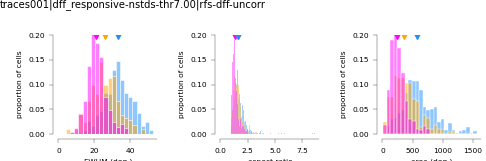

No handles with labels found to put in legend.


/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics hist_per-area_metrics


fwhm_avg                                                        \
               count       mean       std        min        25%        50%   
visual_area                                                                  
Li             373.0  33.239836  7.593435  14.186013  28.325986  33.015422   
Lm             213.0  25.911880  7.730988   4.192896  20.391013  26.053769   
V1             546.0  21.335970  5.348768   7.753588  18.040273  20.791040   

                                  aspect_ratio            ...            \
                   75%        max        count      mean  ...       75%   
visual_area                                               ...             
Li           38.260519  52.820103        373.0  1.817151  ...  1.993582   
Lm           30.970883  46.675816        213.0  1.628632  ...  1.772155   
V1           24.070651  38.785655        546.0  1.423403  ...  1.520007   

                        area                                                 \
                  max  count        mean         std        min         25%   
visual_area                                                                   
Li           8.675383  373.0  608.859000  280.980505  77.529152  427.681067   
Lm           3.352857  213.0  391.558455  222.234271   9.030843  228.738961   
V1           3.568268  546.0  264.614100  133.179879  33.913805  176.396252   

                                                  
                    50%         75%          max  
visual_area                                       
Li           567.515025  762.035086  1565.608267  
Lm           351.648292  521.703267  1148.452531  
V1           236.027000  321.609755   785.081282  

[3 rows x 24 columns]

In [488]:
%matplotlib notebook
means_= finaldf.groupby('visual_area').median()
plot_params = ['fwhm_avg', 'aspect_ratio', 'area']
name_lut = {'fwhm_avg': 'FWHM (deg.)',
            'aspect_ratio': 'aspect ratio',
            'area': 'area (deg.)'}
fig, axn = pl.subplots(1,len(plot_params), figsize=(6,2))

ylim=0.2
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=finaldf, ax=ax,
                 hue='visual_area', hue_order=visual_areas,palette=area_colors, 
                 stat='probability', common_norm=False, edgecolor='w')
    ax.legend_.remove()
    ax.set_xlim([0, ax.get_xlim()[-1]])
    for va, vc in area_colors.items():
        m = float(means_.loc[va, par])
        ax.plot(m, ylim, color=vc, marker='v')
    ax.set_ylim([0, ylim])
    ax.set_box_aspect(1)
    ax.set_xlabel(name_lut[par])
    ax.set_ylabel('proportion of cells')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pplot.adjust_subplots(bottom=0.25)
sns.despine(offset=4)

pplot.label_figure(fig, data_id)
figname = 'hist_per-area_metrics'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)
finaldf.groupby(['visual_area'])[plot_params].describe()

<IPython.core.display.Javascript object>


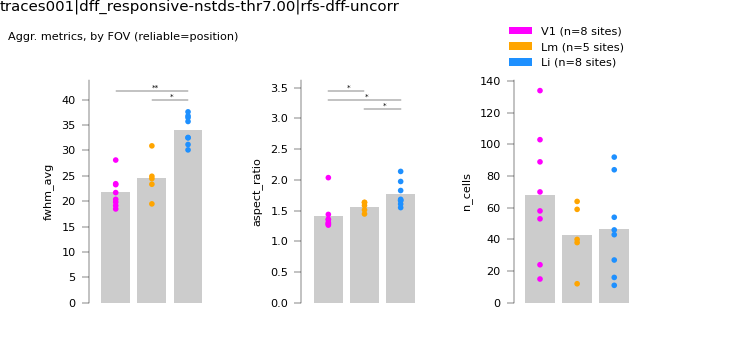

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics per-area_metrics_byFOV
fwhm_avg ----------------------------
             count   mean   std    min    25%    50%    75%    max
visual_area                                                       
Li             8.0  34.12  2.86  30.12  32.16  34.14  36.56  37.61
Lm             5.0  24.63  4.12  19.48  23.35  24.46  24.93  30.92
V1             8.0  21.80  3.14  18.48  19.65  21.04  23.32  28.12
aspect_ratio ----------------------------
             count  mean   std   min   25%   50%   75%   max
visual_area                                                 
Li             8.0  1.76  0.20  1.55  1.65  1.67  1.86  2.14
Lm             5.0  1.56  0.08  1.44  1.51  1.58  1.63  1.63
V1             8.0  1.41  0.26  1.26  1.29  1.33  1.38  2.03
n_cells ----------------------------
             count   mean    std   min    25%   50%   75%    max
visual_area                                                    

In [502]:
%matplotlib notebook
means_= finaldf.groupby('visual_area').median()

plot_params = ['fwhm_avg', 'aspect_ratio', 'n_cells']
name_lut = {'fwhm_avg': 'FWHM (deg.)',
            'aspect_ratio': 'aspect ratio',
            'n_cells': 'Num. cells with RFs'
           }
fig, axn = pl.subplots(1,len(plot_params), figsize=(6,3),dpi=150)
fov_meds = finaldf.groupby(['visual_area', 'datakey']).median().reset_index()

for ax, par in zip(axn.flat, plot_params):
    y_loc=np.ceil(fov_meds[par].max())
    offset = y_loc/20.
    pplot.stripplot_metric_by_area(fov_meds, ax=ax, metric=par,markersize=3,
                            area_colors=area_colors, posthoc='fdr_bh',
                            y_loc=y_loc+offset, offset=offset, #ylim=(0, 1.03),
                            aspect=2, sig_fontsize=4, jitter=False,
                            return_stats=True, plot_means=True,
                            mean_style='bar', mean_type='mean'   )
    ax.set_xticklabels('')

va_labels = dict((va, '%s (n=%i sites)' % (va, len(g['datakey'].unique()))) \
             for va, g in fov_meds.groupby('visual_area'))
leg_h = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas],
                                   labels=[va_labels[v] for v in visual_areas],
                                   linestyles='', use_patch=True)
ax.legend(handles=leg_h, bbox_to_anchor=(1.01,1.01), loc='lower right', 
          frameon=False, markerscale=0.25)
pplot.adjust_subplots(bottom=0.25, right=0.8)
sns.despine(offset=4, bottom=True)
fig.text(0.01, 0.9, 'Aggr. metrics, by FOV (reliable=position)')

pplot.label_figure(fig, data_id)
figname = 'per-area_metrics_byFOV'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)
for par in plot_params:
    print("%s ----------------------------" % par)
    print(fov_meds.groupby(['visual_area'])[par].describe().round(2))
    

In [28]:
projdf = sct.stack_axes(aligned_soma)

projdf['deg_scatter_abs'] = projdf['deg_scatter'].abs()
projdf['dist_scatter_abs'] = projdf['dist_scatter'].abs()

In [32]:
az_min, az_max = (-60, 60)
az_step = 2
az_bins = np.arange(az_min, az_max+az_step, az_step)

el_min, el_max = (-40, 40)
el_step = 2
el_bins = np.arange(az_min, az_max+az_step, az_step)

df = finaldf.copy()
df = cr.cut_bins(df, az_bins, 'x0')
df = cr.cut_bins(df, el_bins, 'y0')

<IPython.core.display.Javascript object>


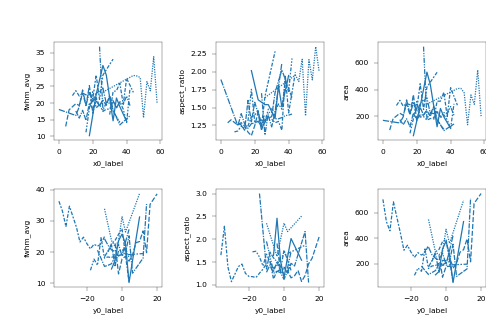

In [36]:
plot_params = ['fwhm_avg', 'aspect_ratio', 'area']

fig, axn = pl.subplots(2, len(plot_params), figsize=(6,4), sharex=False, sharey=False)
for pi, param in enumerate(plot_params):
    for ai, axcond in enumerate(['x0', 'y0']):
        x_var = '%s_label' % axcond
        fov_means = df.groupby(['visual_area', 'datakey', x_var]).median().reset_index()
        plotd = fov_means[(fov_means.visual_area=='V1')]
        ax=axn[ai, pi]
        sns.lineplot(x=x_var, y=param, style='datakey', data=plotd, ax=ax,
                    lw=1)
        ax.legend_.remove()
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, wspace=0.5, hspace=0.5)
# ax=axn[1]
# sns.scatterplot(x='y0', y='fwhm_avg', data=df_, ax=ax)
# ax=axn[0]
# sns.scatterplot(x='x0', y='fwhm_avg', data=df_, ax=ax)
# ax=axn[1]
# sns.scatterplot(x='y0', y='fwhm_avg', data=df_, ax=ax)

In [37]:
axis_colors={'az': 'blue', #[0.7]*3,
             'el': 'orange'} #[0.5]*3}

<IPython.core.display.Javascript object>


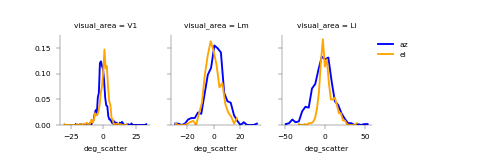

<IPython.core.display.Javascript object>


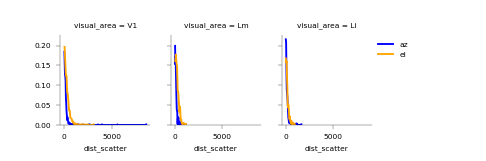

In [45]:
x_var = 'deg_scatter'
%matplotlib notebook
plot_cdf=False
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                   #row='experiment', row_order=['rfs', 'rfs10'],
                  data=projdf, hue='axis', palette=axis_colors, height=2,
                  sharex=False)
fg.map(sns.histplot, x_var, cumulative=plot_cdf, element='poly', fill=False,
      common_norm=False, stat='probability')
for ax in fg.fig.axes:
    ax.set_box_aspect(1)
    
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.7, bottom=0.3, top=0.8)
x_var = 'dist_scatter'
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=projdf, hue='axis', palette=axis_colors, height=2)
fg.map(sns.histplot, x_var, cumulative=plot_cdf, element='poly', fill=False,
      common_norm=False, stat='probability')
for ax in fg.fig.axes:
    ax.set_box_aspect(1)
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pl.subplots_adjust(left=0.1, right=0.7, bottom=0.3, top=0.8)

## Greater scatter with eccentricity?

In [108]:
az_min, az_max = (0, 60)
az_step = 5.
x_bins = np.arange(az_min, az_max+az_step, az_step)

df = projdf.copy()
df = cr.cut_bins(df, x_bins, 'eccentricity')
df = cr.cut_bins(df, x_bins, 'eccentricity_ctr')

<IPython.core.display.Javascript object>


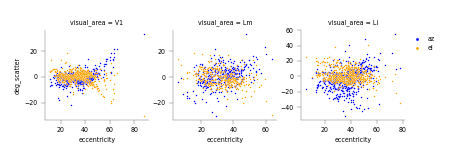

In [109]:

fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=df, hue='axis', palette=axis_colors, height=2,
                  sharex=False, sharey=False)
fg.map(sns.scatterplot, 'eccentricity', 'deg_scatter', s=2)
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                       markerscale=2)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
#sns.scatterplot(x='rf_pos', y='deg_scatter', ax=ax, data=projdf)

<IPython.core.display.Javascript object>


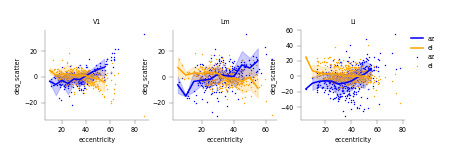

In [112]:
y_var='deg_scatter'
dist_var = 'eccentricity'
scatter_kws = {'size': 2}
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=df, hue='axis', palette=axis_colors, height=2,
                  sharex=False, sharey=False)
fg.map(sns.scatterplot, dist_var, y_var, s=2)
fg.set_titles('{col_name}')
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                       markerscale=2)

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

x_var='%s_label' % dist_var
binned_df = df.groupby(['visual_area', 'datakey', 'axis', 'experiment',
                       x_var]).mean().reset_index()
for ai, ax in enumerate(fg.fig.axes):
    plotd = binned_df[binned_df.visual_area==ax.title.get_text()].copy()
    sns.lineplot(x=x_var, y=y_var, hue='axis', data=plotd, ax=ax,
                palette=axis_colors, ci='sd')
    if ai==2:
        ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
    else:
        ax.legend_.remove()
#     sns.lineplot(x=x_var, y=y_var, data=plotd, ax=ax,
#                  color='k',  ci='sd')

<IPython.core.display.Javascript object>


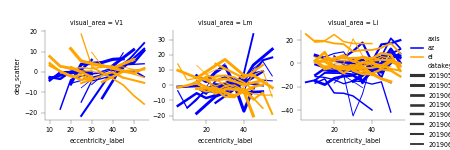

In [113]:
x_var='eccentricity_label'
binned_df = df.groupby(['visual_area', 'datakey', 'axis', 'experiment',
                       x_var])\
              .mean().reset_index()
plotd = binned_df.copy()
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=plotd, height=2,
                  sharex=False, sharey=False)
fg.map(sns.lineplot, x_var, 'deg_scatter', 'axis', 'datakey',
       hue='axis', palette=axis_colors) #, scatter_kws=scatter_kws)
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                       markerscale=2)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

## RF size ("CMF" for single-cell) vs. eccentricity?

<IPython.core.display.Javascript object>


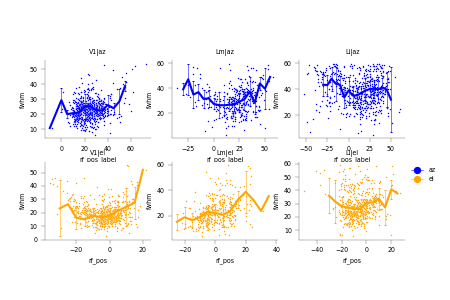

In [114]:
scatter_kws = {'s': 2}
y_var = 'fwhm' # 'vectorproj'
dist_var='rf_pos'
az_min, az_max = (-30, 60)
az_step = 5.
x_bins = np.arange(az_min, az_max+az_step, az_step)
df = projdf.copy()
df = cr.cut_bins(df, x_bins, dist_var)
# -----------------------------------------------------------------
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas,data=df, 
                   row='axis',
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.scatterplot, dist_var, y_var, s=2)
fg.set_titles('{col_name}|{row_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
x_var='%s_label' % dist_var
binned_df = df.groupby(['visual_area', 'datakey', 'axis', 'experiment',
                       x_var]).mean().reset_index()
for ai, ax in enumerate(fg.fig.axes):
    va, cnd = ax.title.get_text().split('|')
    plotd = binned_df[(binned_df.visual_area==va) & (binned_df.axis==cnd)].copy()
    sns.lineplot(x=x_var, y=y_var, data=plotd, ax=ax,
                 hue='axis', palette=axis_colors, 
                 ci='sd', err_style='bars',
                 lw=2, err_kws={'elinewidth':0.5, 'capsize':0.5})
    ax.legend_.remove()
leg_h = pplot.custom_legend_markers(colors=[axis_colors[c] for c in ['az', 'el']],
                                   labels=['az', 'el'])
fg.axes.flat[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', 
                        frameon=False, markerscale=1)

<IPython.core.display.Javascript object>


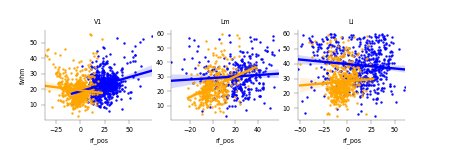

<IPython.core.display.Javascript object>


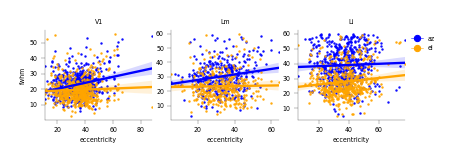

In [115]:
scatter_kws = {'s': 2}
y_var = 'fwhm' # 'vectorproj'
x_var='rf_pos'
# -----------------------------------------------------------------
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas,data=df, 
                  #row='axis', 
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.regplot, x_var, y_var,scatter_kws=scatter_kws)# s=2)
fg.set_titles('{col_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

x_var='eccentricity'
# -----------------------------------------------------------------
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas,data=df, 
                  #row='axis', 
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.regplot, x_var, y_var,scatter_kws=scatter_kws)# s=2)
fg.set_titles('{col_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

leg_h = pplot.custom_legend_markers(colors=[axis_colors[c] for c in ['az', 'el']],
                                   labels=['az', 'el'])
fg.axes.flat[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', 
                        frameon=False, markerscale=1)

<IPython.core.display.Javascript object>


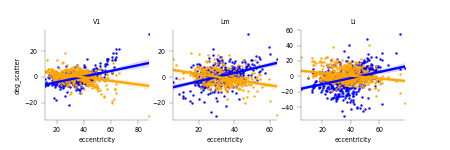

<IPython.core.display.Javascript object>


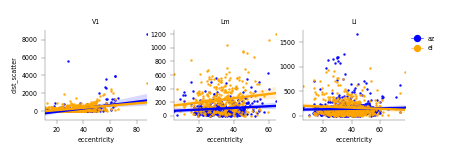

In [116]:
x_var = 'eccentricity'
y_var = 'deg_scatter'
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=projdf, 
                  #row='axis', 
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.regplot, x_var, y_var, scatter_kws=scatter_kws)
fg.set_titles('{col_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

x_var = 'eccentricity'
y_var = 'dist_scatter'
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=projdf, 
                  #row='axis', 
                  hue='axis', palette=axis_colors,
                  height=2, sharex=False, sharey=False)
fg.map(sns.regplot, x_var, y_var, scatter_kws=scatter_kws)
fg.set_titles('{col_name}')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

#legend
leg_h = pplot.custom_legend_markers(colors=[axis_colors[c] for c in ['az', 'el']],
                                   labels=['az', 'el'])
fg.axes.flat[-1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left', 
                        frameon=False, markerscale=1)

In [117]:
projdf['deg_scatter_abs'] = projdf['deg_scatter'].abs()

In [118]:
cnts_fov = pd.concat([pd.DataFrame({'visual_area': va,
               'datakey': dk, 
               'n_cells': len(g['cell'].unique())}, index=[i])\
              for i, ((va, dk), g) in enumerate(df.groupby(['visual_area', 'datakey']))])

for (va, dk), g in df.groupby(['visual_area', 'datakey']):
    df.loc[g.index, 'n_cells'] = len(g['cell'].unique()) #len(df[() & ()]['cell'].unique())
    
binned_df = df.groupby(['visual_area', 'datakey', 'axis', 'experiment',
                       x_var]).mean().reset_index()

<IPython.core.display.Javascript object>


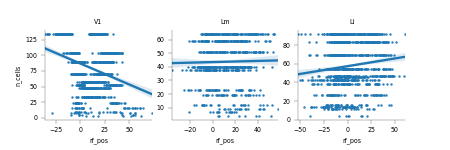

No handles with labels found to put in legend.


In [120]:
y_var = 'n_cells'
x_var =  dist_var # '%s_label' % dist_var
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                  data=binned_df, palette=axis_colors, height=2,
                  sharex=False, sharey=False)
fg.map(sns.regplot, dist_var, y_var, scatter_kws=scatter_kws)
fg.set_titles('{col_name}')
fg.axes.flat[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
                       markerscale=2)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)


# Aggregate RF comparisons

In [128]:
va='V1'
dk='20190617_JC097_fov1'
df_ = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()


In [148]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [149]:
diffs = cr.get_pw_rf_diffs(df_)
diffs.head()

,neuron_pair,cell_1,cell_2,rf_angle_diff,rf_angle_diff_abs,std_x,std_y,aspect_ratio,rf_distance,max_ecc,min_ecc,cortical_distance
0,2_4,2,4,-18.054274,18.054274,0.523727,1.443144,0.265733,0.528452,37.971013,37.868868,28.925336
1,2_21,2,21,-40.337231,40.337231,2.071493,2.744454,0.043426,4.645020,37.971013,33.367259,173.407980
2,2_24,2,24,-10.904453,10.904453,5.022730,2.708593,0.139090,3.661556,37.971013,35.267235,255.860257
3,2_25,2,25,-27.924389,27.924389,1.832507,0.890939,0.079702,3.882982,37.971013,34.794594,275.607469
4,2_26,2,26,-30.033266,30.033266,2.181121,2.739271,0.024010,3.073550,37.971013,35.012558,269.231332


In [130]:
rois_ = df_['cell'].unique()
curr_polys = rfpolys[(rfpolys.datakey==dk) & (rfpolys['cell'].isin(rois_))]
print(dk, curr_polys.shape)
if len(curr_polys)<=1:
    print("NONE, skipping overlaps")  
overlaps_ = rfutils.get_rf_overlaps(curr_polys)
overlaps_ = overlaps_.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})
overlaps_['neuron_pair'] = ['%i_%i' % (c1, c2) for c1, c2 \
                                in overlaps_[['cell_1', 'cell_2']].values] 

20190617_JC097_fov1 (77, 3)


In [133]:
from functools import reduce

In [150]:
dfs_to_merge=[diffs, overlaps_]

# combine
pw_df = reduce(lambda  left,right: pd.merge(left,right,\
                                    on=['neuron_pair', 'cell_1', 'cell_2'],
                                    how='outer'), dfs_to_merge)

In [151]:
diffs.columns

Index(['neuron_pair', 'cell_1', 'cell_2', 'rf_angle_diff', 'rf_angle_diff_abs',
       'std_x', 'std_y', 'aspect_ratio', 'rf_distance', 'max_ecc', 'min_ecc',
       'cortical_distance'],
      dtype='object')

In [152]:
overlaps_.columns

Index(['cell_1', 'cell_2', 'area_overlap', 'perc_overlap', 'neuron_pair'], dtype='object')

In [156]:
rf_diff_params

['neuron_pair',
 'rf_angle_diff',
 'rf_angle_diff_abs',
 'std_x',
 'std_y',
 'aspect_ratio',
 'rf_distance',
 'max_ecc',
 'min_ecc',
 'cortical_distance',
 'area_overlap',
 'perc_overlap']

<IPython.core.display.Javascript object>


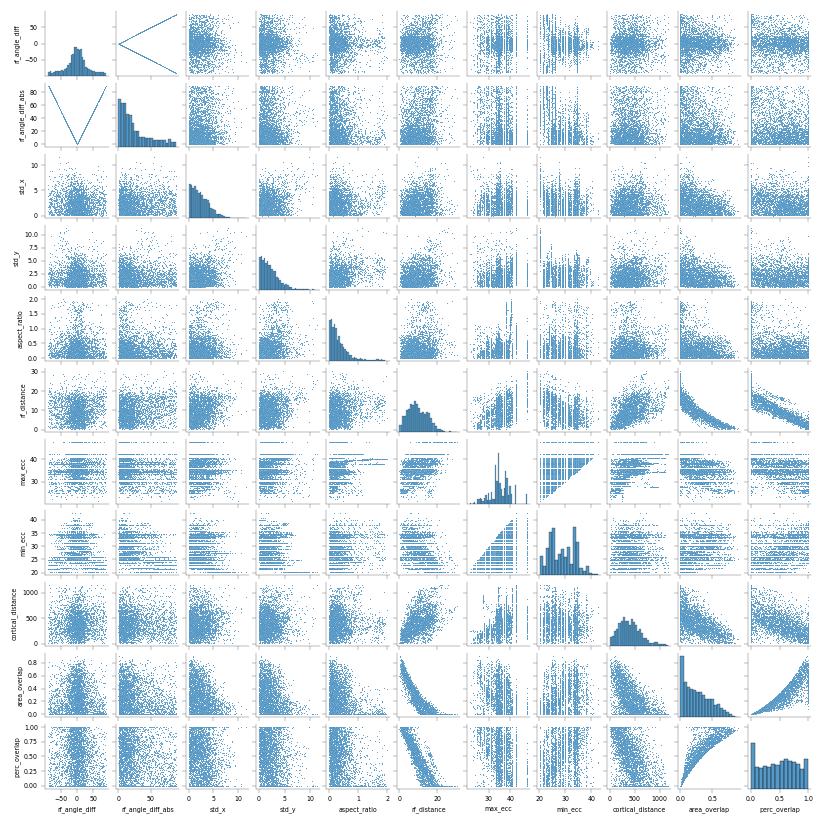

In [159]:
rf_diff_params = [c for c in pw_df.columns \
                  if c not in ['neuron_pair', 'cell_1', 'cell_2']]
sns.pairplot(pw_df, vars=rf_diff_params, height=1, plot_kws={'s':1})
pl.savefig(os.path.join(examples_dir, 'pairplot_rf_metrics.svg'))


# AGG

In [46]:
DISTS = cr.aggregate_rf_dists(finaldf, rfpolys=rfpolys)

20190527_JC092_fov3 (46, 3)
20190528_JC092_fov1 (11, 3)
20190602_JC091_fov1 (84, 3)
20190612_JC099_fov1 (54, 3)
20190614_JC091_fov1 (92, 3)
20190617_JC099_fov1 (16, 3)
20191017_JC113_fov1 (43, 3)
20191106_JC120_fov1 (26, 3)
20190430_JC078_fov1 (38, 3)
20190504_JC078_fov1 (9, 3)
20190508_JC083_fov1 (64, 3)
20190525_JC084_fov1 (40, 3)
20190603_JC080_fov1 (59, 3)
20190618_JC097_fov1 (12, 3)
20190627_JC091_fov1 (7, 3)
20190501_JC076_fov1 (9, 3)
20190507_JC083_fov1 (58, 3)
20190508_JC083_fov1 (15, 3)
20190522_JC084_fov1 (134, 3)
20190613_JC097_fov1 (70, 3)
20190616_JC097_fov1 (103, 3)
20190617_JC097_fov1 (89, 3)
20190622_JC085_fov1 (24, 3)
20191006_JC110_fov1 (53, 3)


In [47]:
DISTS['area_overlap'] = DISTS['area_overlap'].astype(float)
DISTS['perc_overlap'] = DISTS['perc_overlap'].astype(float)
DISTS.groupby('visual_area').count()

,neuron_pair,cell_1,cell_2,rf_angle_diff,rf_angle_diff_abs,std_x,std_y,aspect_ratio,rf_distance,max_ecc,min_ecc,cortical_distance,area_overlap,perc_overlap,datakey,n_cells
visual_area,,,,,,,,,,,,,,,,
Li,11567,11567,11567,11567,11567,11567,11567,11567,11567,11567,11567,11567,11541,11541,11567,11567
Lm,5333,5333,5333,5333,5333,5333,5333,5333,5333,5333,5333,5333,5333,5333,5333,5333
V1,23943,23943,23943,23943,23943,23943,23943,23943,23943,23943,23943,23943,23943,23943,23943,23943


## Binned distance decay plots

In [49]:
DISTS['overlap_index'] = 1 - DISTS['area_overlap']

In [305]:
equal_bins=False
n_bins=10

df = DISTS.copy()
# Split distances into X um bins
ctx_maxdist = np.ceil(DISTS['cortical_distance'].max())
ctx_step=10
if equal_bins:
    ctx_bins = np.linspace(0, ctx_maxdist, n_bins)
else:
    ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
rf_maxdist = np.ceil(DISTS['rf_distance'].max())
if equal_bins:
    rf_bins = np.linspace(0, rf_maxdist, n_bins)
else:
    rf_bins = np.arange(0, rf_maxdist+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

perc_step = 0.02
if equal_bins:
    perc_bins = np.linspace(0, 1, n_bins)
else:
    perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'overlap_index')
# Split
dist_lut = {'cortical_distance': 
                        {'bins': ctx_bins, 'step': ctx_step, 'max_dist': ctx_maxdist},
            'rf_distance': 
                        {'bins': rf_bins, 'step': rf_step, 'max_dist': rf_maxdist},
            'overlap_index': 
                        {'bins': perc_bins, 'step': perc_step, 'max_dist': 1} 
           }

<IPython.core.display.Javascript object>


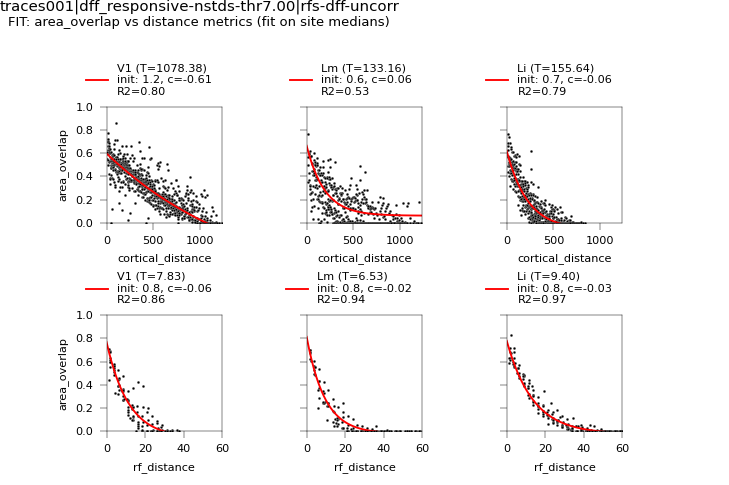

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics avgfov_decay-fit-area_overlap_dist-metrics


In [314]:
%matplotlib notebook
metric='area_overlap'
ylim = (0, 1)

dist_vars=['cortical_distance', 'rf_distance']

fit_sites = True
fit_str = 'avgfov' if fit_sites else 'cellpairs' 

use_binned=False
min_npairs = 3
n_iter=int(np.random.rand(1)[0]*500)
   
fig, axn = pl.subplots(2,3, figsize=(6,4), dpi=150, sharex=False, sharey=True)
for va, vg in df.groupby('visual_area'):
    for ai, dist_var in enumerate(dist_vars):
        ax=axn[ai, visual_areas.index(va)]
        x_var = '%s_label' % dist_var
        curr_maxdist = dist_lut[dist_var]['max_dist']
        cnt_groups = [x_var, 'datakey'] if fit_sites else [x_var]
        nsamples_per = cr.count_nsamples_per_bin(vg, cnt_groups, min_npairs=10)
        if len(nsamples_per)==0:
            print("    no samples, %s, %s" % (va))
        res_, xvals, yvals = cr.sample_bins_and_fit(vg, nsamples_per, cnt_groups, 
                                        to_quartile=dist_var, metric=metric, 
                                        use_binned=use_binned, normalize_x=True, 
                                        func='halflife', estimator='median',
                                        resample=True)
        if all(res_.isnull()):
            print("BINNED, no fit: %s" % va)
            label='no fit'
        else:
            xvals = np.linspace(0, curr_maxdist, 100)
            fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
            label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                            % (va, res_.tau, res_.init, res_.constant, res_.R2)
            ax.plot(xvals, fit_y, color='r', label=label, lw=1)
        # plot
        if fit_sites:
            meas_cc = vg.groupby(cnt_groups).median().reset_index() #.dropna()
        else:
            meas_cc = vg.copy()
        sns.scatterplot(x=dist_var, y=metric, data=meas_cc, s=2, color='k', ax=ax)
        ax.set_xlim([0, curr_maxdist])
        if dist_var=='rf_distance':
            ax.set_xlim([0, 60])
        ax.set_ylim(ylim)
        ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=1)
        ax.set_box_aspect(1)
pl.subplots_adjust(bottom=0.2, left=0.1, right=0.8, top=0.8, hspace=0.8)

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.95, 'FIT: %s vs distance metrics (fit on site medians)' % metric, 
         fontsize=7)

figname = '%s_decay-fit-%s_dist-metrics' % (fit_str, metric)
pl.savefig(os.path.join(dst_dir, '%s.svg'% figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


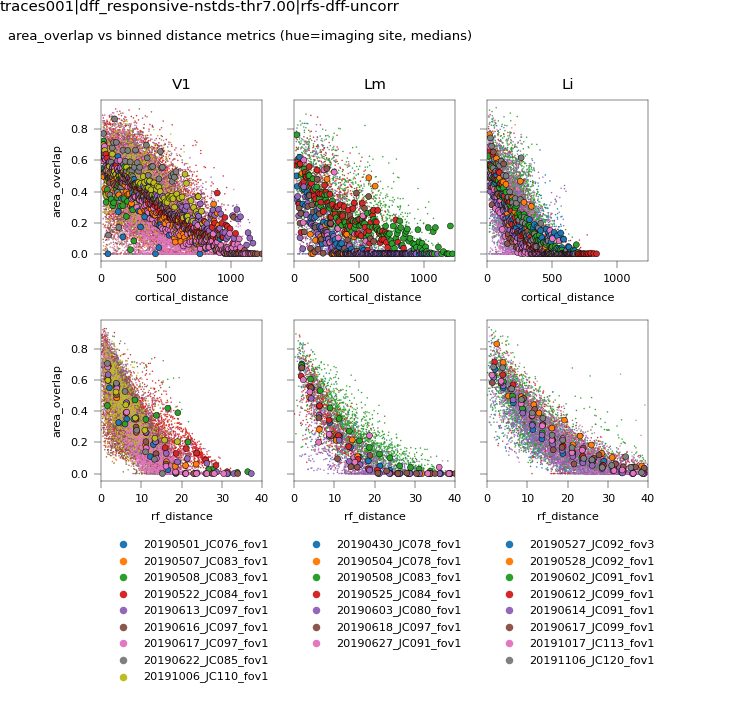

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics avgfov_decay-fit-area_overlap_dist-metrics_rawdata-FOV


In [315]:
fig, axn = pl.subplots(2, 3, figsize=(6,6), dpi=150, sharex=False, sharey=True)
# vg = df[df.visual_area=='Lm'].copy()

for va, vg in df.groupby('visual_area'):
    for ri, dist_var in enumerate(['cortical_distance', 'rf_distance']):
        ax=axn[ri, visual_areas.index(va)]
        # plot
        x_var = '%s_label' % dist_var
        curr_maxdist = dist_lut[dist_var]['max_dist']
        cnt_groups = [x_var, 'datakey'] if fit_sites else [x_var]

        meas_cc = vg.groupby([x_var, 'datakey']).median().reset_index() #.dropna()
        hue_order = sorted(vg['datakey'].unique(),key=hutils.natural_keys)
        sns.scatterplot(x=dist_var, y=metric, data=vg, ax=ax, 
                        hue='datakey', hue_order=hue_order, edgecolor=None, 
                        s=0.5, legend=None)
        sns.scatterplot(x=dist_var, y=metric, data=meas_cc, ax=ax, 
                        hue='datakey', hue_order=hue_order, edgecolor='k', 
                        s=10, legend=ri==1)
        ax.set_xlim([0, curr_maxdist])
        if ri==0:
            ax.set_title(va)
        if ri==1:
            ax.legend(bbox_to_anchor=(0, -0.3), loc='upper left', frameon=False, 
                         markerscale=0.5, fontsize=6)
            ax.set_xlim([0, 40])    
        ax.set_box_aspect(1)
pl.subplots_adjust(bottom=0.4, right=0.8, hspace=0.3)

pplot.label_figure(fig, data_id)
fig.text(0.01, 0.95, '%s vs binned distance metrics (hue=imaging site, medians)' % metric, 
         fontsize=7)

figname = '%s_decay-fit-%s_dist-metrics_rawdata-FOV' % (fit_str, metric)
pl.savefig(os.path.join(dst_dir, '%s.svg'% figname))
print(dst_dir, figname)

In [398]:
nsamples_per

{0.0: 14,
 2.5: 29,
 5.0: 29,
 7.5: 33,
 10.0: 33,
 12.5: 26,
 15.0: 17,
 17.5: 21,
 20.0: 19,
 22.5: 24,
 25.0: 14,
 27.5: 15}

# Fit by site

In [327]:
dk_lut = dict((va, dict((v, i) for i, v in enumerate(vg['datakey'].unique()))) \
     for va, vg in df.groupby('visual_area'))
     
for va, vg in df.groupby('visual_area'):
    df.loc[vg.index, 'site_num'] = [dk_lut[va][k] for k in vg['datakey'].values]

In [455]:
fit_sites=False
min_npairs=10 # N pairs PER BIN
min_npoints=5
too_few_pairs = dict((k, []) for k in visual_areas)
r_list = []
for dist_var in dist_vars:
    x_var = '%s_label' % dist_var
    cnt_groups = [x_var, 'datakey'] if fit_sites else [x_var]
    for (va, dk), df_ in df.groupby(['visual_area', 'datakey']):
        # fit
        nsamples_per = cr.count_nsamples_per_bin(df_, cnt_groups, 
                                                 min_npairs=min_npairs)
        if len(nsamples_per)<min_npoints:
            # print("    no samples, %s, %s" % (va, dk))
            too_few_pairs[va].append(dk)
            continue
        res_, xvals, yvals = cr.sample_bins_and_fit(df_, nsamples_per, cnt_groups, 
                                        to_quartile=dist_var, metric=metric, 
                                        use_binned=use_binned, normalize_x=True, 
                                        func='halflife', estimator='median', 
                                        resample=False)
        res_['visual_area'] = va
        res_['datakey'] = dk
        res_['site_num'] = dnum
        res_['distance'] = dist_var
        res_['n_pairs'] = len(df_['neuron_pair'].unique())
        r_list.append(res_)
fov_results = pd.concat(r_list, axis=1, ignore_index=True).T
cols = [k for k in fov_results.columns if k \
        not in ['visual_area', 'datakey', 'distance']]
for c in cols:
    fov_results[c] = fov_results[c].astype(float)
fov_results.head()

,init,tau,constant,R2,visual_area,datakey,site_num,distance,n_pairs
0,0.595888,102.478083,0.072199,0.903441,Li,20190527_JC092_fov3,8.0,cortical_distance,1035.0
1,0.893626,362.376251,-0.308709,0.981585,Li,20190602_JC091_fov1,8.0,cortical_distance,3486.0
2,0.808880,135.138601,-0.066694,0.946748,Li,20190612_JC099_fov1,8.0,cortical_distance,1431.0
3,0.583252,121.806537,-0.044315,0.974210,Li,20190614_JC091_fov1,8.0,cortical_distance,4186.0
4,0.579252,103.812465,-0.026328,0.772379,Li,20191017_JC113_fov1,8.0,cortical_distance,903.0


In [456]:
pass0 = pd.concat([g for (va, dk), g in fov_results.groupby(['visual_area', 'datakey']) 
            if dk not in too_few_pairs[va]])
pass_results = pass0[(pass0.R2>0.5) & (pass0.R2<1)].copy()

<IPython.core.display.Javascript object>


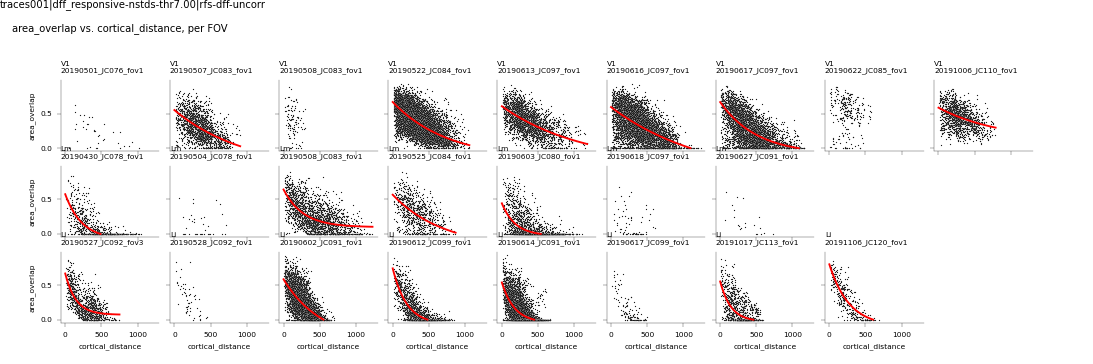

BINNED, no fit: V1
BINNED, no fit: V1
BINNED, no fit: V1
BINNED, no fit: Lm
BINNED, no fit: Lm
BINNED, no fit: Lm
BINNED, no fit: Li
BINNED, no fit: Li
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics each_site_area_overlap_v_cortical_distance


<IPython.core.display.Javascript object>


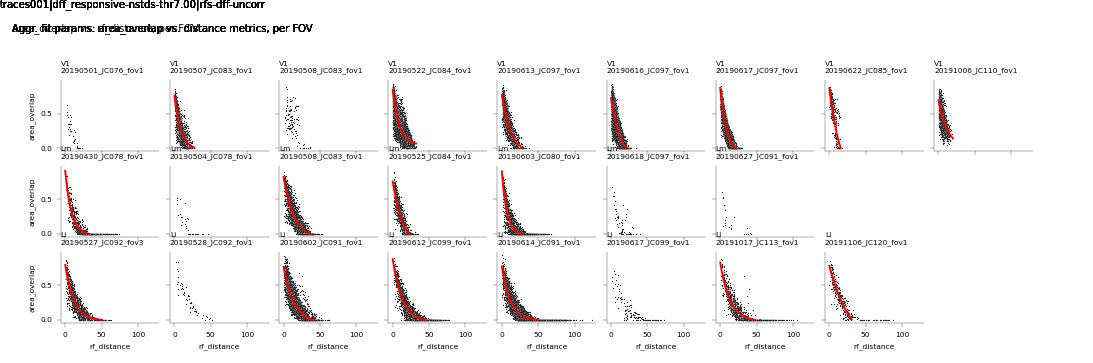

BINNED, no fit: V1
BINNED, no fit: V1
BINNED, no fit: Lm
BINNED, no fit: Lm
BINNED, no fit: Lm
BINNED, no fit: Li
BINNED, no fit: Li
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics each_site_area_overlap_v_rf_distance


In [457]:
#dist_var='rf_distance'
for dist_var in dist_vars:
    x_var = '%s_label' % dist_var
    curr_maxdist = dist_lut[dist_var]['max_dist']
    cnt_groups = [x_var, 'datakey'] if fit_sites else [x_var]
    #
    fg = sns.FacetGrid(data=df, row='visual_area', row_order=visual_areas,
                       col='site_num', height=1.5, aspect=1)
    fg.map(sns.scatterplot, dist_var, metric, s=1, color='k')
    fg.set_titles('{row_name}|{col_name}')
    for ax in fg.fig.axes:
        va, dnum = ax.get_title().split('|')
        dks = [k for k, v in dk_lut[va].items() if v==float(dnum)]
        if len(dks)==0:
            ax.axis('off')
            ax.set_title('')
            continue
        dk=dks[0]
        ax.set_title('')
        ax.set_title('%s\n%s' % (va, dk), loc='left', fontsize=6)
        curr_res = pass_results[(pass_results.visual_area==va) 
                          & (pass_results.datakey==dk) 
                          & (pass_results.distance==dist_var)].copy()
        if len(curr_res)==0:
            print("BINNED, no fit: %s" % va)
            label='no fit'
        else:
            df_ = df[(df.visual_area==va) & (df.datakey==dk)].copy()
            curr_xmin = df_[x_var].max()+dist_lut[dist_var]['step']
            xvals = np.linspace(0, curr_xmin, 100)
            res_ = pd.Series(curr_res.iloc[0])            
            fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
            valid_ = np.array([i for i, v in enumerate(fit_y) if v>=0])
            label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                            % (va, res_.tau, res_.init, res_.constant, res_.R2)
            ax.plot(xvals[valid_], fit_y[valid_], color='r', label=label)
    pl.subplots_adjust(left=0.05, right=0.85, bottom=0.2, top=0.8,hspace=0.2)
    fg.fig.text(0.01, 0.92, '%s vs. %s, per FOV' % (metric, dist_var), fontsize=8)
    pplot.label_figure(fg.fig, data_id)
    figname = 'each_site_%s_v_%s' % (metric, dist_var)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

<IPython.core.display.Javascript object>


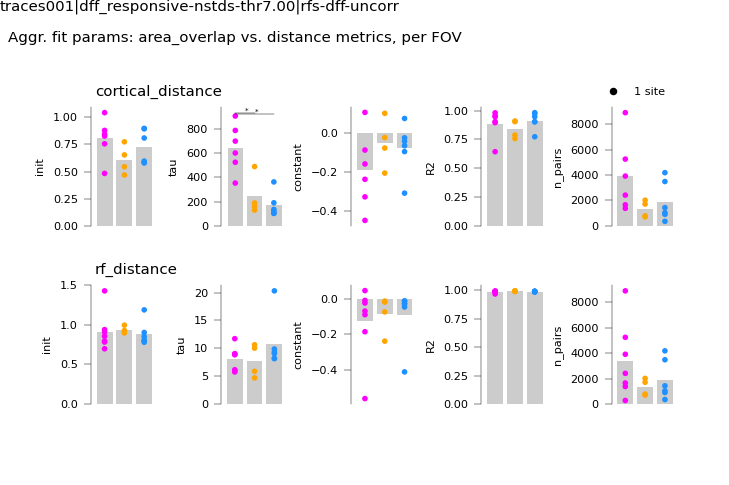

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics each_site_area_overlap_aggr_results


In [468]:
plot_params = ['init', 'tau', 'constant', 'R2', 'n_pairs']
dist_vars = ['cortical_distance', 'rf_distance']

fig, axn = pl.subplots(2, len(plot_params), figsize=(6,4), dpi=150)
for ri, (dist_var, df_) in enumerate(pass_results.dropna().groupby('distance')):
    for ci, param in enumerate(plot_params):
        ax=axn[ri, ci]
        y_loc= np.ceil(df_[param].max())
        offset = y_loc/100.
        pplot.stripplot_metric_by_area(df_, ax=ax, metric=param, markersize=3,
                            area_colors=area_colors, posthoc='fdr_bh',
                            y_loc=y_loc+offset, offset=offset, #ylim=(0, 1.03),
                            aspect=2, sig_fontsize=4, jitter=False,
                            return_stats=True, plot_means=True,
                            mean_style='bar', mean_type='mean'   )
        ax.set_xticklabels('')
        if ci==0:
            ax.set_title(dist_var, loc='left', fontsize=8)

ax=axn[0, -1]
leg_h = pplot.custom_legend_markers(colors=['k'], labels=['1 site'],linestyles=''
                               )
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), frameon=False, loc='lower right',
         markerscale=0.5)
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.25, top=0.8, wspace=0.5, hspace=0.5)
fig.text(0.01, 0.92, 'Aggr. fit params: %s vs. distance metrics, per FOV' \
                % (metric), fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'each_site_%s_aggr_results' % (metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

## Example FOV plot

<IPython.core.display.Javascript object>


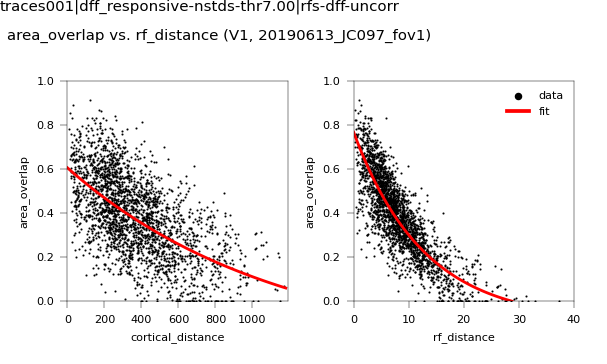

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics/examples rf_area_overlap_vs_distances_EX_V1


In [536]:
va='V1'
dk='20190613_JC097_fov1'
fovdf = df[(df.visual_area==va) & (df.datakey==dk)].copy()
fovres = pass_results[(pass_results.visual_area==va) 
                      & (pass_results.datakey==dk)].copy()

fig, axn = pl.subplots(1, 2, figsize=(5,3), dpi=150)

for ci, dist_var in enumerate( ['cortical_distance', 'rf_distance']):
    ax=axn[ci]
    x_var = '%s_label' % dist_var
    # datapoints
    sns.scatterplot(x=dist_var, y=metric, data=fovdf, ax=ax, 
                        edgecolor=None, s=1, legend=None, color='k', alpha=1)
    # fit
    curr_res = fovres[fovres.distance==dist_var].copy()
    stp = dist_lut[dist_var]['step']
    curr_xmax = fovdf[x_var].max()+dist_lut[dist_var]['step']
    xvals = np.linspace(0, curr_xmax, 100)
    res_ = pd.Series(curr_res.iloc[0])            
    fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
    valid_ = np.array([i for i, v in enumerate(fit_y) if v>=0])
    label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                            % (va, res_.tau, res_.init, res_.constant, res_.R2)
    ax.plot(xvals[valid_], fit_y[valid_], color='r', label=label)
    ax.set_ylim((0,1))
    ax.set_xlim((0, curr_xmax+stp))
    ax.set_box_aspect(1)
    
leg_h = pplot.custom_legend_markers(colors=['k', 'r'],
                                   labels=['data', 'fit'], lws=[0, 2],
                                   linestyles=['', '-'], markers=['o', None])
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper right', frameon=False,
         markerscale=0.5)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.25, top=0.8, wspace=0.3)
fig.text(0.01, 0.9, '%s vs. %s (%s, %s)' % (metric, dist_var, va, dk), fontsize=8)
pplot.label_figure(fig, data_id)
figname = 'rf_%s_vs_distances_EX_%s' % (metric, va)
pl.savefig(os.path.join(examples_dir, '%s.svg' % figname))
pl.savefig(os.path.join(FIGDIR, '%s.svg' % figname))

print(examples_dir, figname)

## All fits

<IPython.core.display.Javascript object>


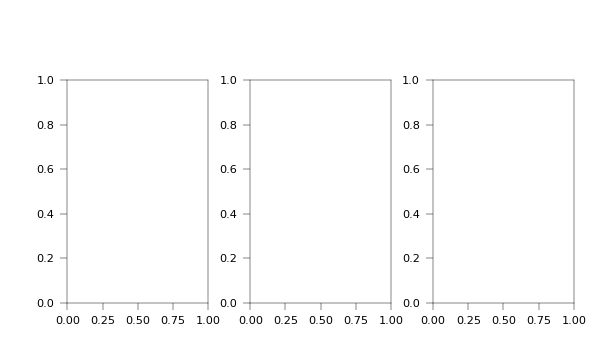

In [543]:
fig, axn = pl.subplots(1, 3, figsize=(5,3), dpi=150)
dist_var = 'cortical_distance'

for (va, dk), fovdf in df.groupby(['visual_area', 'datakey']):
    ax=axn[visual_areas.index(va)]
    x_var = '%s_label' % dist_var
    # fit
    fovres = pass_results[(pass_results.visual_area==va) 
                      & (pass_results.datakey==dk)].copy()
    if len(fovres)==0:
        continue

#     stp = dist_lut[dist_var]['step']
#     curr_xmax = df[x_var].max()+dist_lut[dist_var]['step']
#     xvals = np.linspace(0, curr_xmax, 100)
#     res_ = pd.Series(curr_res.iloc[0])            
#     fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
#     valid_ = np.array([i for i, v in enumerate(fit_y) if v>=0])
#     ax.plot(xvals[valid_], fit_y[valid_], color='k', lw=0.5)
#     ax.set_ylim((0,1))
#     ax.set_xlim((0, curr_xmax+stp))
#     ax.set_box_aspect(1)
#     ax.set_title(va)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.25, top=0.8, wspace=0.3)


<IPython.core.display.Javascript object>


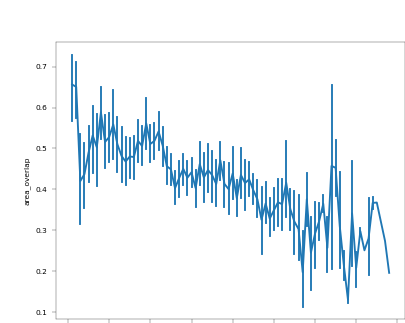

<AxesSubplot:xlabel='cortical_distance_label', ylabel='area_overlap'>

In [546]:
fig, ax = pl.subplots()
sns.lineplot(x=x_var, y=metric, data=fovdf, ax=ax,
            err_style='bars')

<IPython.core.display.Javascript object>


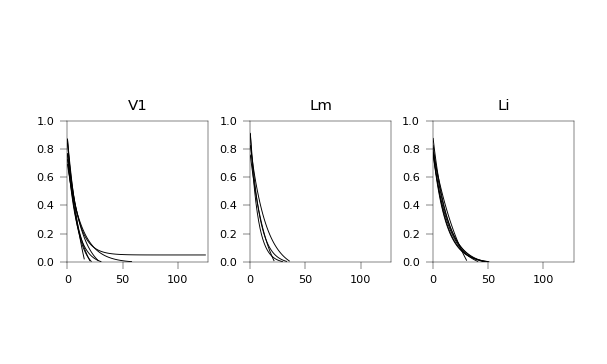

In [547]:
fig, axn = pl.subplots(1, 3, figsize=(5,3), dpi=150)
dist_var = 'rf_distance'

for (va, dk), vg in pass_results.groupby(['visual_area', 'datakey']):
    ax=axn[visual_areas.index(va)]
    x_var = '%s_label' % dist_var
    # fit
    curr_res = vg[vg.distance==dist_var].copy()
    if len(curr_res)==0:
        continue
    stp = dist_lut[dist_var]['step']
    curr_xmax = df[x_var].max()+dist_lut[dist_var]['step']
    xvals = np.linspace(0, curr_xmax, 100)
    res_ = pd.Series(curr_res.iloc[0])            
    fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
    valid_ = np.array([i for i, v in enumerate(fit_y) if v>=0])
    ax.plot(xvals[valid_], fit_y[valid_], color='k', lw=0.5)
    ax.set_ylim((0,1))
    ax.set_xlim((0, curr_xmax+stp))
    ax.set_box_aspect(1)
    ax.set_title(va)

pl.subplots_adjust(left=0.1, right=0.85, bottom=0.25, top=0.8, wspace=0.3)


In [538]:
curr_res

,init,tau,constant,R2,visual_area,datakey,site_num,distance,n_pairs


In [310]:
cnts_lut_ = dict((k[0], v) for k, v in nsamples_per.items())
df_['n_pairs'] = [cnts_lut_[i] if i in list(cnts_lut_.keys()) else np.nan\
                  for i in df_[x_var].values]

In [311]:
meds_ = df_.groupby([x_var]).median().reset_index()

<IPython.core.display.Javascript object>


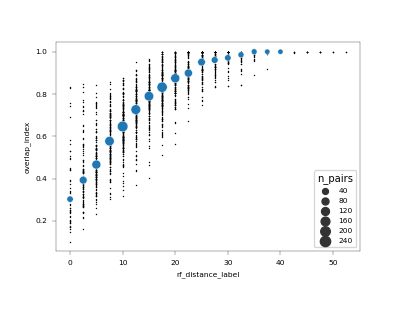

In [313]:
fig, ax = pl.subplots()

sns.scatterplot(x=x_var,y=metric, data=df_, ax=ax, s=1,
                color='k', edgecolor=None)

sns.scatterplot(x=x_var,y=metric, data=meds_, ax=ax, size='n_pairs')

pl.subplots_adjust(bottom=0.3, right=0.8)

# Bootstrap decay fit

In [257]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [293]:
use_binned = False # Average the values in each bin, then fit.
fit_sites = True # Only average within-animal
use_quartile=False
metric='area_overlap'
to_quartile='cortical_distance'
# --------------------------------------------------
ymax = 1 if metric=='area_overlap' else None

cut_str = 'qcut' if use_quartile else 'cut'
bin_str = 'fitbin' if use_binned else 'fitraw'
fit_str = 'avgfov' if fit_sites else 'cellpairs' 
bin_type = '%s-%s-%s' % (cut_str, bin_str, fit_str)
print('Fitting: %s' % bin_type)
n_iterations=100
# Fit function
resdf = cr.bootstrap_fitdecay(df.dropna(), use_binned=use_binned, 
                         fit_sites=fit_sites,
                         metric=metric, to_quartile=to_quartile,
                         bin_column='bin_value', normalize_x=True, ymax=ymax,
                         n_iterations=n_iterations)
for p in ['R2', 'init', 'tau', 'constant']:
    resdf[p] = resdf[p].astype(float)
print(resdf[resdf['R2']>0.5].shape)

Fitting: cut-fitraw-avgfov
(240, 6)


In [294]:
print("init: %i/%i iters too big" % (resdf[resdf.init>1].shape[0], n_iterations))
print("init: %i/%i iters too small" % (resdf[resdf.init<=-1].shape[0], n_iterations))

print("tau: %i/%i iters too big" % (resdf[resdf.tau>1200].shape[0], n_iterations))
print("tau: %i/%i iters too small" % (resdf[resdf.init<=0].shape[0], n_iterations))


init: 100/100 iters too big
init: 0/100 iters too small
tau: 0/100 iters too big
tau: 0/100 iters too small


In [295]:
resdf = resdf[resdf.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]

if use_binned:
    print("is binned, checking R2")
    finalres = resdf[(resdf['init']<=1.2) & (resdf['init']>=-1.2) 
                   & (resdf['tau']<=2000) & (resdf['tau']>=0)
                   & (resdf['R2']>0.5)].copy().dropna()
else:
    finalres = resdf[(resdf['init']<=1) & (resdf['init']>=-1) 
                   & (resdf['tau']<=1200) & (resdf['tau']>=0)].copy().dropna()
                   #& (resdf['R2']>0.5)].copy()
print(resdf.shape, finalres.shape)

(300, 6) (200, 6)


In [296]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

cortical distance (um)
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics cortical_distance_v_area_overlap_curves_cut-fitraw-avgfov


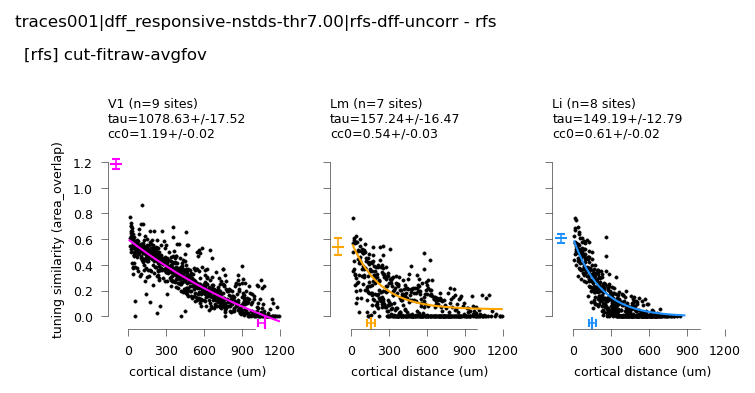

In [303]:
ylim=(-0.1,1.3)
%matplotlib inline
if to_quartile=='area_overlap':
    x_pos = -0.1
    xlabel='RF overlap (%)'
    max_dist = 1
else:
    x_pos = -100 if to_quartile=='cortical_distance' else -5
    y_pos = -0.05 if metric=='area_overlap' else -0.75
    xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'
    max_dist = 1200 if to_quartile=='cortical_distance' else 40
    
ylabel='tuning similarity (%s)' % metric
print(xlabel)
use_best_r2=False
fig = cr.plot_fit_distance_curves(df, resdf.dropna(),  metric=metric, 
                            to_quartile=to_quartile, 
                            use_best_r2=use_best_r2, fit_sites=fit_sites,
                            area_colors=area_colors, 
                            x_pos=x_pos, y_pos=y_pos, elinewidth=0.75,
                            ylim=ylim, xlabel=xlabel, ylabel=ylabel)
fig.patch.set_alpha(1)
for ax in fig.axes:
    yticks=np.linspace(0, 1.2, 7)
    ax.set_yticks(yticks)
    ax.set_yticklabels([round(i, 2) for i in yticks])
    xticks = np.linspace(0, max_dist, 5)
    ax.set_xticks(xticks)
pl.subplots_adjust(bottom=0.3, right=0.8)
fig.text(0.01, 0.9, '[%s] %s' \
             % (experiment, bin_type), fontsize=8)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
figname = '%s_v_%s_curves_%s' % (to_quartile,metric, bin_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [304]:
for va, vg in resdf.groupby('visual_area'):
    print('%s --------------------' % va)
    print(vg.describe())
    

Li --------------------
             init         tau    constant          R2
count  100.000000  100.000000  100.000000  100.000000
mean     0.609903  149.555558   -0.003293    0.765734
std      0.016184   12.793899    0.019460    0.022769
min      0.559644  118.713908   -0.054931    0.695291
25%      0.601775  141.425252   -0.014735    0.753848
50%      0.610185  149.191628   -0.003687    0.767740
75%      0.620353  156.371694    0.006479    0.783444
max      0.643511  192.474925    0.050619    0.807639
Lm --------------------
             init         tau    constant          R2
count  100.000000  100.000000  100.000000  100.000000
mean     0.533522  157.591674    0.052997    0.496173
std      0.034847   16.472795    0.009767    0.037019
min      0.456740  124.497294    0.027758    0.420054
25%      0.508467  146.399213    0.045969    0.470125
50%      0.535223  157.244776    0.052581    0.492559
75%      0.552038  166.443400    0.059654    0.516387
max      0.634141  203.801317    0

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics param_distns_cortical_distance_v_area_overlap_cut-fitraw-avgfov


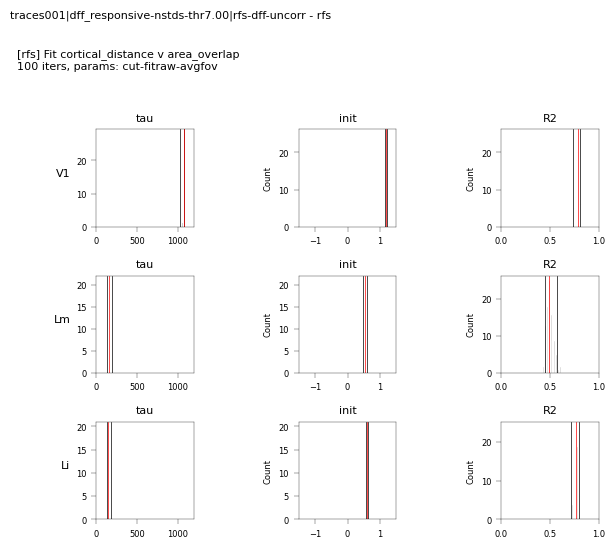

In [305]:
if to_quartile=='area_overlap':
    tau_lim = 1.5
else:
    tau_lim=1200 if to_quartile=='cortical_distance' else 80
fig, axn = pl.subplots(3,3, figsize=(6.75,6))
fig.patch.set_alpha(1)

for va, rd_ in resdf.dropna().groupby('visual_area'):
    for pi, param in enumerate(['tau', 'init', 'R2']):
        ax=axn[visual_areas.index(va), pi]
        sns.histplot(x=param, data=rd_, ax=ax, color=[0.8]*3, 
                    edgecolor='w', stat='count', alpha=1)
        ci_lo, ci_hi = hutils.get_empirical_ci(rd_[param].values)
        ax.axvline(x=ci_lo, color='k', lw=0.5)
        ax.axvline(x=ci_hi, color='k', lw=0.5)
        med = rd_[param].median()
        ax.axvline(x=med, color='r', lw=0.5)
        ax.set_title(param)
        ax.set_xlabel('')
        if param=='tau':
            ax.set_xlim([0, tau_lim])
        elif param=='init':
            ax.set_xlim([-1.5, 1.5])
        elif param=='R2':
            ax.set_xlim([0, 1])
        ax.set_box_aspect(1)
    axn[visual_areas.index(va), 0].set_ylabel(va, fontsize=8, rotation=0, ha='right')
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, hspace=0.5, wspace=0.5, top=0.8)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
fig.text(0.01, 0.9, "[%s] Fit %s v %s\n%i iters, params: %s" 
    % (experiment, to_quartile, metric, n_iterations, bin_type), 
         fontsize=8)

figname = 'param_distns_%s_v_%s_%s' % (to_quartile, metric, bin_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [192]:
# dist_var='cortical_distance'
# ctx_maxdist=1200
# ctx_step=25
# ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)

# rf_maxdist=60
# rf_step=5
# rf_bins = np.arange(0, rf_maxdist+rf_step, rf_step)

# dist_bins = copy.copy(ctx_bins) if dist_var=='cortical_distance' \
#                 else copy.copy(rf_bins)

# diffs = cr.cut_bins(diffs, dist_bins, dist_var)

# grp_step=100 if dist_var=='cortical_distance' else 15
# grp_max = 1000 if dist_var=='cortical_distance' else 60
# grp_bins = np.arange(0, grp_max+grp_step, grp_step)
# diffs['group_value'] = pd.cut(diffs[dist_var], grp_bins, 
#                             include_lowest=True, labels=grp_bins[0:-1])
# diffs['group_label'] = [int(d) if not np.isnan(d) else d \
#                              for d in diffs['group_value'].values]

In [242]:
import pingouin as pg

In [243]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds/rfs_uncorr_metrics'

In [244]:
# experiment = 'rfs'
# responsive_test='nstds'
# trial_epoch='stimulus'
# # ----------------------------------------------------------------
# response_type='dff'
# responsive_thr=7.0 if experiment=='rfs' else 10.
# n_stds=2.5
# n_bootstrap_iters=500
# print(responsive_test, responsive_thr)
# # Responsive params
# resp_desc = '%s_responsive-%s-thr%.2f' \
#                 % (response_type, responsive_test, responsive_thr)
# data_id = '|'.join([traceid, resp_desc])
# print(data_id)
# #### Load all metdata and assigned cells
# sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
# experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
# meta = sdata[sdata.experiment.isin(experiment_list)].copy()
# #### Output dir
# cc_dir = os.path.join(aggregate_dir, 'correlations', 
#                        '%s_%s_%s' % (experiment, response_type, responsive_test))
# if not os.path.exists(cc_dir):
#     os.makedirs(cc_dir)
# print(cc_dir)

In [469]:
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in rf_ukeys], ignore_index=True)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_rfs10_trialmeans_traces001_nstds-thr-7.00_dff_stimulus.pkl


In [471]:
finaldf['experiment'].unique()

array(['rfs10', 'rfs'], dtype=object)

In [246]:
select_stimuli='fullfield'
distance_var = 'rf_distance'
min_ncells=10
CORRS = cr.aggregate_ccdist(NDATA, experiment=experiment, rfdf=rfdf,
                        SDF=None, select_stimuli=select_stimuli,min_ncells=min_ncells,
                        distance_var=distance_var, verbose=True)

Dist: rf_distance
0 datasets w wrong configs:
0 datasets w/out RF fits:


In [247]:
CORRS.head()

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,rf_distance,max_ecc,min_ecc,cortical_distance,visual_area,datakey,experiment,n_cells
0,1,2,0.722867,1_2,0.194088,9.843133,29.971839,29.339362,31.138301,Li,20190527_JC092_fov3,rfs,65
1,1,4,0.612922,1_4,0.012481,3.956535,29.339362,28.662374,69.239792,Li,20190527_JC092_fov3,rfs,65
2,1,5,0.603857,1_5,0.168463,4.544876,29.339362,26.675416,41.847749,Li,20190527_JC092_fov3,rfs,65
3,1,9,0.370799,1_9,0.083089,8.273882,29.339362,21.579561,98.959469,Li,20190527_JC092_fov3,rfs,65
4,1,14,0.498955,1_14,0.059313,3.166283,29.339362,26.519261,70.586142,Li,20190527_JC092_fov3,rfs,65


In [248]:
CORRS.shape, CORRS.dropna().shape

((202626, 13), (29068, 13))

In [249]:
DISTS.columns

Index(['neuron_pair', 'cell_1', 'cell_2', 'rf_angle_diff', 'rf_angle_diff_abs',
       'std_x', 'std_y', 'aspect_ratio', 'rf_distance', 'max_ecc', 'min_ecc',
       'cortical_distance', 'area_overlap', 'perc_overlap', 'visual_area',
       'datakey', 'n_cells'],
      dtype='object')

In [250]:
CORRS.columns

Index(['cell_1', 'cell_2', 'signal_cc', 'neuron_pair', 'noise_cc',
       'rf_distance', 'max_ecc', 'min_ecc', 'cortical_distance', 'visual_area',
       'datakey', 'experiment', 'n_cells'],
      dtype='object')

In [287]:
ign_cols =  ['experiment', 'signal_cc', 'noise_cc', 'n_cells']
cc_cols = [k for k in CORRS.columns if k not in ign_cols]
DF = pd.merge(DISTS, CORRS, on=cc_cols, how='inner')

<IPython.core.display.Javascript object>


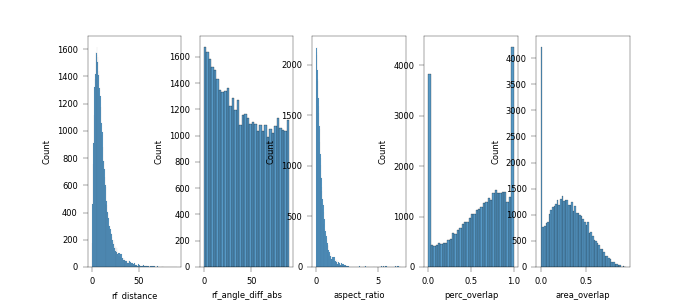

In [296]:
plot_params = ['rf_distance', 'rf_angle_diff_abs', 'aspect_ratio',
               'perc_overlap', 'area_overlap']

fig, axn = pl.subplots(1, len(plot_params), figsize=(7,3))
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=DF, ax=ax)

In [317]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [318]:
ctx_step=20
max_dist=1200
df = DF[DF.cortical_distance<=max_dist].copy()

ctx_dist_bins = np.arange(0, max_dist+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_dist_bins, metric='cortical_distance')

metric = 'rf_angle_diff_abs'
m_bins = np.linspace(0, 90, 13)
df = cr.cut_bins(df, m_bins, metric=metric)

metric = 'aspect_ratio'
step = 0.5
m_bins = np.linspace(0, 3, 30)
df = cr.cut_bins(df, m_bins, metric=metric)

metric = 'perc_overlap'
m_bins = np.linspace(0, 1, 10)
df = cr.cut_bins(df, m_bins, metric=metric)

metric = 'area_overlap'
m_bins = np.linspace(0, 1, 10)
df = cr.cut_bins(df, m_bins, metric=metric)


In [319]:
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

<IPython.core.display.Javascript object>


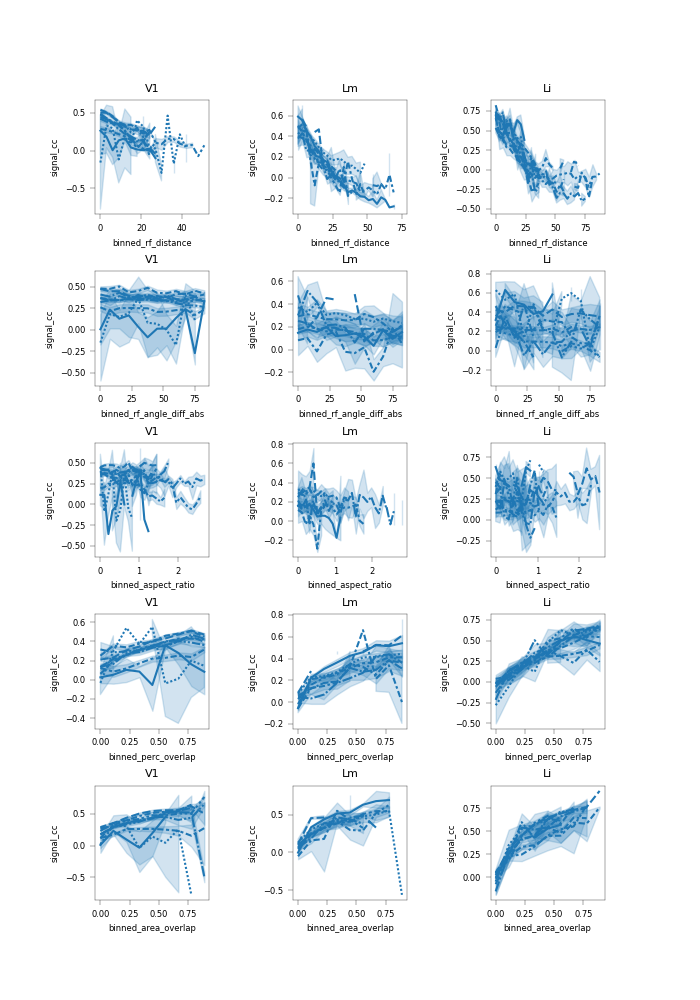

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

In [320]:
y_var = 'signal_cc'
y_var = 'signal_cc'

plot_params = ['rf_distance', 'rf_angle_diff_abs', 'aspect_ratio',
               'perc_overlap', 'area_overlap']

fig, axn = pl.subplots(len(plot_params),3, figsize=(7,10))
for ri, par in enumerate(plot_params):
    for va, vg in df.groupby('visual_area'):
        vi = visual_areas.index(va)
        ax=axn[ri, vi]
        ax.set_title(va)
        sns.lineplot(x='binned_%s' % par, y=y_var, ax=ax, data=vg,
                    style='datakey')
        ax.legend_.remove()
        ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, hspace=0.5, top=0.9)

In [ ]:
rf_angle_diff_abs

## Overlap v. distance

In [ ]:
# Bin cortical distances for plotting
n_bins_dist = 6
n_bins_overlap = 6

use_quartile=False
bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
print("binning: %s" % bin_type)

if use_quartile:
    finaldf['binned_dist'], bin_edges = pd.qcut(finaldf['cortical_distance'], \
                                    n_bins_dist, labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)
else:
    finaldf['binned_dist'], bin_edges = pd.cut(finaldf['cortical_distance'], \
                                     n_bins_dist,labels=False, retbins=True)
    #roi_df['binned_overlap'] = pd.cut(roi_df['perc_overlap'], n_bins_overlap, labels=False)

In [235]:
meanf = finaldf.groupby(['visual_area', 'datakey', 'experiment', 'binned_dist'])\
                .mean().reset_index()

<IPython.core.display.Javascript object>


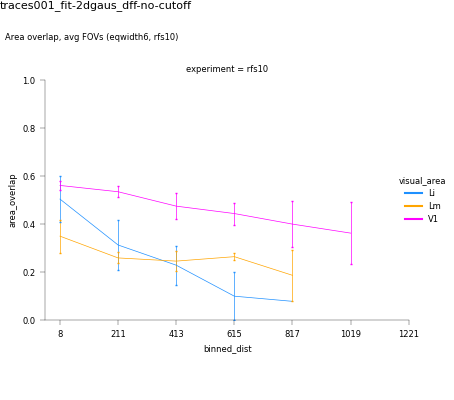

In [236]:
lw=0.5
metric='area_overlap'
fg = sns.relplot(x='binned_dist', y='area_overlap', hue='visual_area',
                 data=meanf, ci='sd', col='experiment', err_style='bars',
                 kind='line', height=4, palette=area_colors,
                 err_kws={'capsize':1, 'lw': lw}, lw=lw)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.9, 'Area overlap, avg FOVs (%s, %s)' % (bin_type, rf_type))

pl.xticks(list(range(len(bin_edges))))
fg.axes.flat[0].set_xticklabels([round(i) for i in bin_edges])
pl.ylim([0, 1])
p3.label_figure(fg.fig, data_id)

figname =  '%s_by_dist_%s__%s' % (metric, bin_type, rf_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


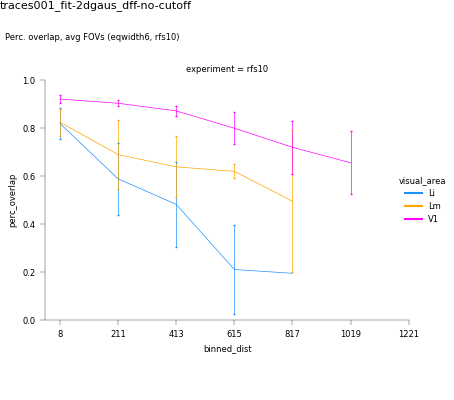

In [237]:
metric='perc_overlap'
fg = sns.relplot(x='binned_dist', y=metric, hue='visual_area',
                 data=meanf, ci='sd', col='experiment', err_style='bars',
                 kind='line', height=4, palette=area_colors,
                err_kws={'capsize':1, 'lw': lw}, lw=lw)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.9, 'Perc. overlap, avg FOVs (%s, %s)' % (bin_type, rf_type))

pl.xticks(list(range(len(bin_edges))))
fg.axes.flat[0].set_xticklabels([round(i) for i in bin_edges])
pl.ylim([0, 1])
p3.label_figure(fg.fig, data_id)

figname =  '%s_by_dist_%s__%s' % (metric, bin_type, rf_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


<IPython.core.display.Javascript object>


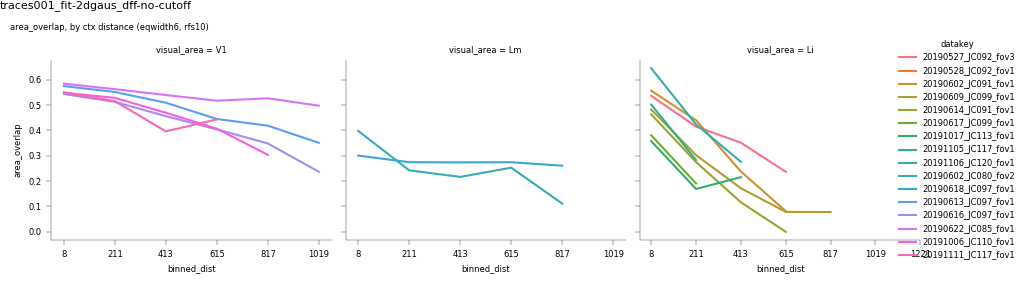

In [240]:
# fig, ax = pl.sublots()
metric = 'area_overlap'
fg = sns.relplot(x='binned_dist', y=metric, hue='datakey',
                 data=meanf,col='visual_area', col_order=visual_areas,
                 kind='line', height=3)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
fg.fig.text(0.01, 0.9, '%s, by ctx distance (%s, %s)' % (metric, bin_type, rf_type))
pl.xticks(list(range(len(bin_edges))))
fg.axes.flat[0].set_xticklabels([round(i) for i in bin_edges])
pl.subplots_adjust(left=0.05, right=0.9)
# fg.axes.flat[0].legend_.remove()
p3.label_figure(fg.fig, data_id)

figname =  'perFOV_%s_by_dist_%s__%s' % (metric, bin_type, rf_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


<IPython.core.display.Javascript object>


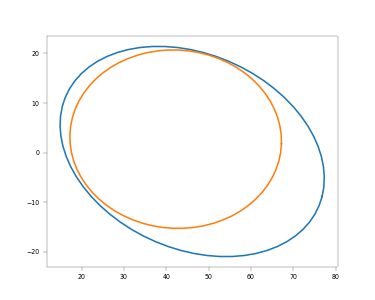

In [256]:
# fig, ax = pl.subplots()
# ax.plot(*rf_polys[4].exterior.xy)
# ax.plot(*rf_polys[11].exterior.xy)


In [ ]:
# # Convert stimuli to polyon bounding boxes
# stim_polys = [(blob_sz, rfutils.stimsize_poly(blob_sz, xpos=stim_xpos, ypos=stim_ypos)) \
#               for blob_sz in stim_sizes[experiment]]